# Structuration du corpus

In [1]:
from src.corpus_structuring import *
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# 1. Chargement et préparation des données
input_file = "articles_processed.pkl"  # Adaptez ce chemin
df = load_processed_data(input_file)
df = prepare_texts_for_clustering(df)

Données chargées avec succès. Shape: (23702, 11)


In [3]:
# 2. Création des représentations vectorielles
vector_rep = VectorRepresentation(df)

# TF-IDF (représentation par mots avec pondération TF-IDF)
vector_rep.create_tfidf_vectors(min_df=5, max_df=0.95)

# Doc2Vec (représentation par plongement lexical)
vector_rep.create_doc2vec_vectors(vector_size=100, min_count=2, epochs=20)

# LDA (représentation thématique)
vector_rep.create_lda_vectors(num_topics=20, passes=10)

Création des vecteurs TF-IDF...
Matrice TF-IDF: 23702 documents × 7673 termes
Création des vecteurs Doc2Vec...
Matrice Doc2Vec: 23702 documents × 100 dimensions
Création des vecteurs LDA (thématiques)...
Matrice LDA: 23702 documents × 20 thématiques

Les termes les plus importants dans chaque thématique:
Thématique 0:
  - game: 0.0200
  - cell: 0.0134
  - games: 0.0129
  - brain: 0.0126
  - disease: 0.0093
  - effects: 0.0079
  - protein: 0.0074
  - patients: 0.0064
  - children: 0.0064
  - cells: 0.0062

Thématique 1:
  - systems: 0.0187
  - software: 0.0179
  - system: 0.0171
  - model: 0.0158
  - process: 0.0112
  - design: 0.0104
  - models: 0.0100
  - test: 0.0083
  - tool: 0.0068
  - use: 0.0065

Thématique 2:
  - image: 0.0344
  - images: 0.0231
  - video: 0.0147
  - recognition: 0.0109
  - features: 0.0096
  - segmentation: 0.0096
  - object: 0.0082
  - visual: 0.0077
  - reconstruction: 0.0073
  - face: 0.0072

Thématique 3:
  - surface: 0.0194
  - path: 0.0160
  - planning: 0

array([[8.38734582e-03, 2.18593124e-02, 1.02642626e-02, ...,
        3.14707682e-03, 8.21484551e-02, 1.73630584e-02],
       [1.15432602e-03, 3.88434976e-02, 1.41867239e-03, ...,
        4.33323265e-04, 1.21158175e-03, 8.42115879e-02],
       [1.42816052e-01, 3.98692548e-01, 1.78608578e-02, ...,
        5.47457207e-03, 1.52990818e-02, 3.00685037e-02],
       ...,
       [1.66589450e-02, 4.25812975e-02, 2.04061866e-02, ...,
        6.25801319e-03, 1.74862612e-02, 3.42796892e-02],
       [1.16652166e-02, 3.36882174e-01, 1.42858159e-02, ...,
        4.37923335e-03, 1.22365737e-02, 2.45743729e-02],
       [1.05952229e-02, 1.18708216e-01, 1.29806520e-02, ...,
        3.98011599e-03, 1.11306384e-02, 4.55304593e-01]])

In [4]:
# 3. Clustering des documents
clustering = DocumentClustering(df, vector_rep.vector_representations)

# K-means avec représentation TF-IDF
labels_kmeans_tfidf = clustering.apply_kmeans(
    vector_rep.vector_representations['tfidf'],
    n_clusters=8,
    representation_name='tfidf'
)

# K-means avec représentation Doc2Vec
labels_kmeans_doc2vec = clustering.apply_kmeans(
    vector_rep.vector_representations['doc2vec'],
    n_clusters=8,
    representation_name='doc2vec'
)

# K-means avec représentation LDA
labels_kmeans_lda = clustering.apply_kmeans(
    vector_rep.vector_representations['lda'],
    n_clusters=8,
    representation_name='lda'
)

# Comparaison des résultats
comparison_df = clustering.compare_clustering_results()
display(comparison_df)

Application de K-means avec 8 clusters sur tfidf...
Métriques d'évaluation:
  - silhouette: 0.0052
  - davies_bouldin: 9.8266
  - calinski_harabasz: 70.9359

Distribution des clusters:
  - Cluster 0: 988 documents (4.2%)
  - Cluster 1: 2357 documents (9.9%)
  - Cluster 2: 4861 documents (20.5%)
  - Cluster 3: 1803 documents (7.6%)
  - Cluster 4: 1016 documents (4.3%)
  - Cluster 5: 259 documents (1.1%)
  - Cluster 6: 1968 documents (8.3%)
  - Cluster 7: 10450 documents (44.1%)
Application de K-means avec 8 clusters sur doc2vec...
Métriques d'évaluation:
  - silhouette: 0.2187
  - davies_bouldin: 3.6037
  - calinski_harabasz: 669.2218

Distribution des clusters:
  - Cluster 0: 1153 documents (4.9%)
  - Cluster 1: 1561 documents (6.6%)
  - Cluster 2: 2211 documents (9.3%)
  - Cluster 3: 1855 documents (7.8%)
  - Cluster 4: 1369 documents (5.8%)
  - Cluster 5: 2471 documents (10.4%)
  - Cluster 6: 10812 documents (45.6%)
  - Cluster 7: 2270 documents (9.6%)
Application de K-means avec 8 c

,method,algorithm,representation,n_clusters,silhouette,davies_bouldin,calinski_harabasz
1,kmeans_8_doc2vec,kmeans,doc2vec,8,0.218745,3.603747,669.221801
2,kmeans_8_lda,kmeans,lda,8,0.184539,1.850475,2513.449142
0,kmeans_8_tfidf,kmeans,tfidf,8,0.005159,9.826592,70.935902


Visualisation des clusters avec tsne...


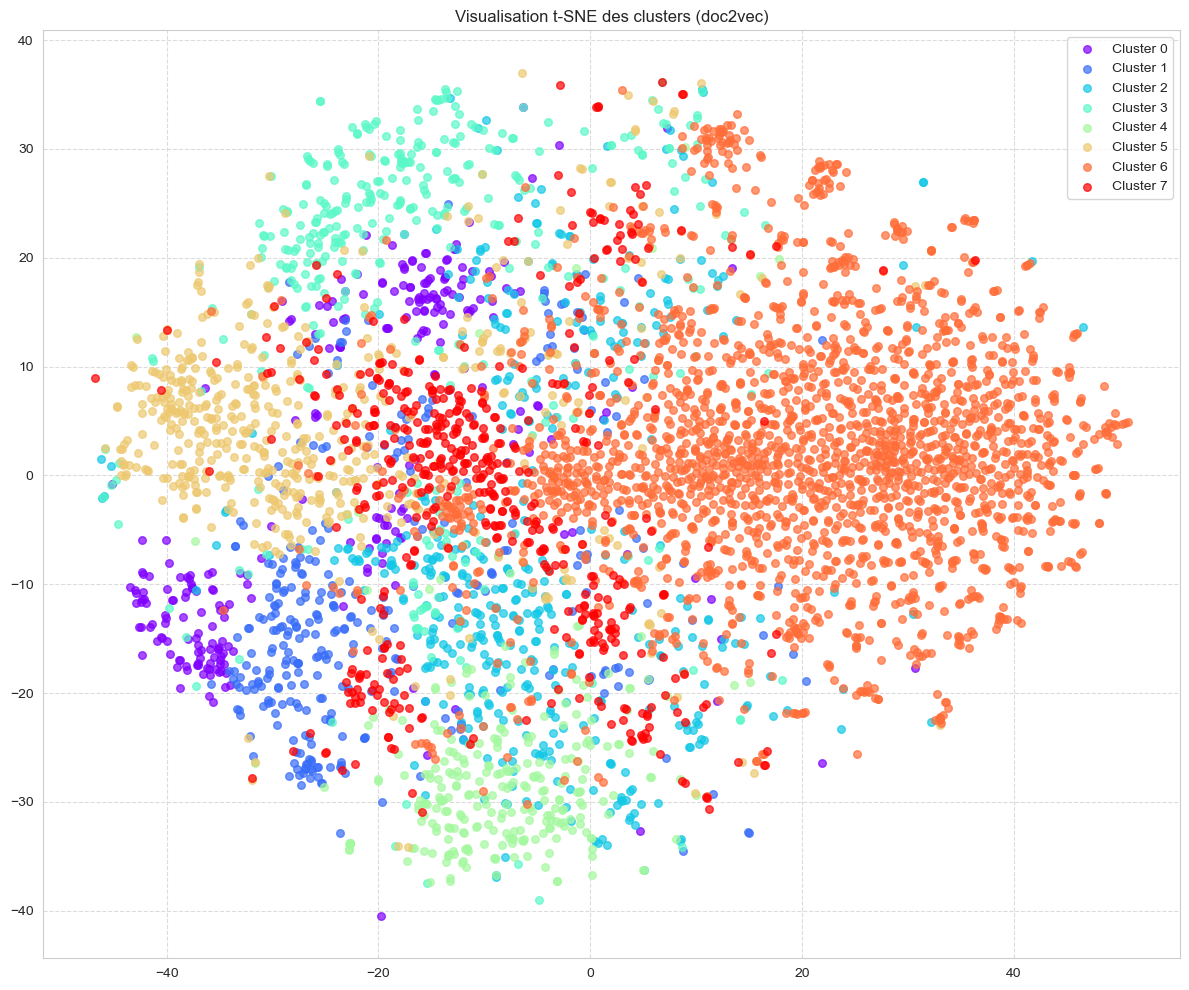

Extraction des termes les plus représentatifs par cluster...
Visualisation des termes les plus représentatifs par cluster...


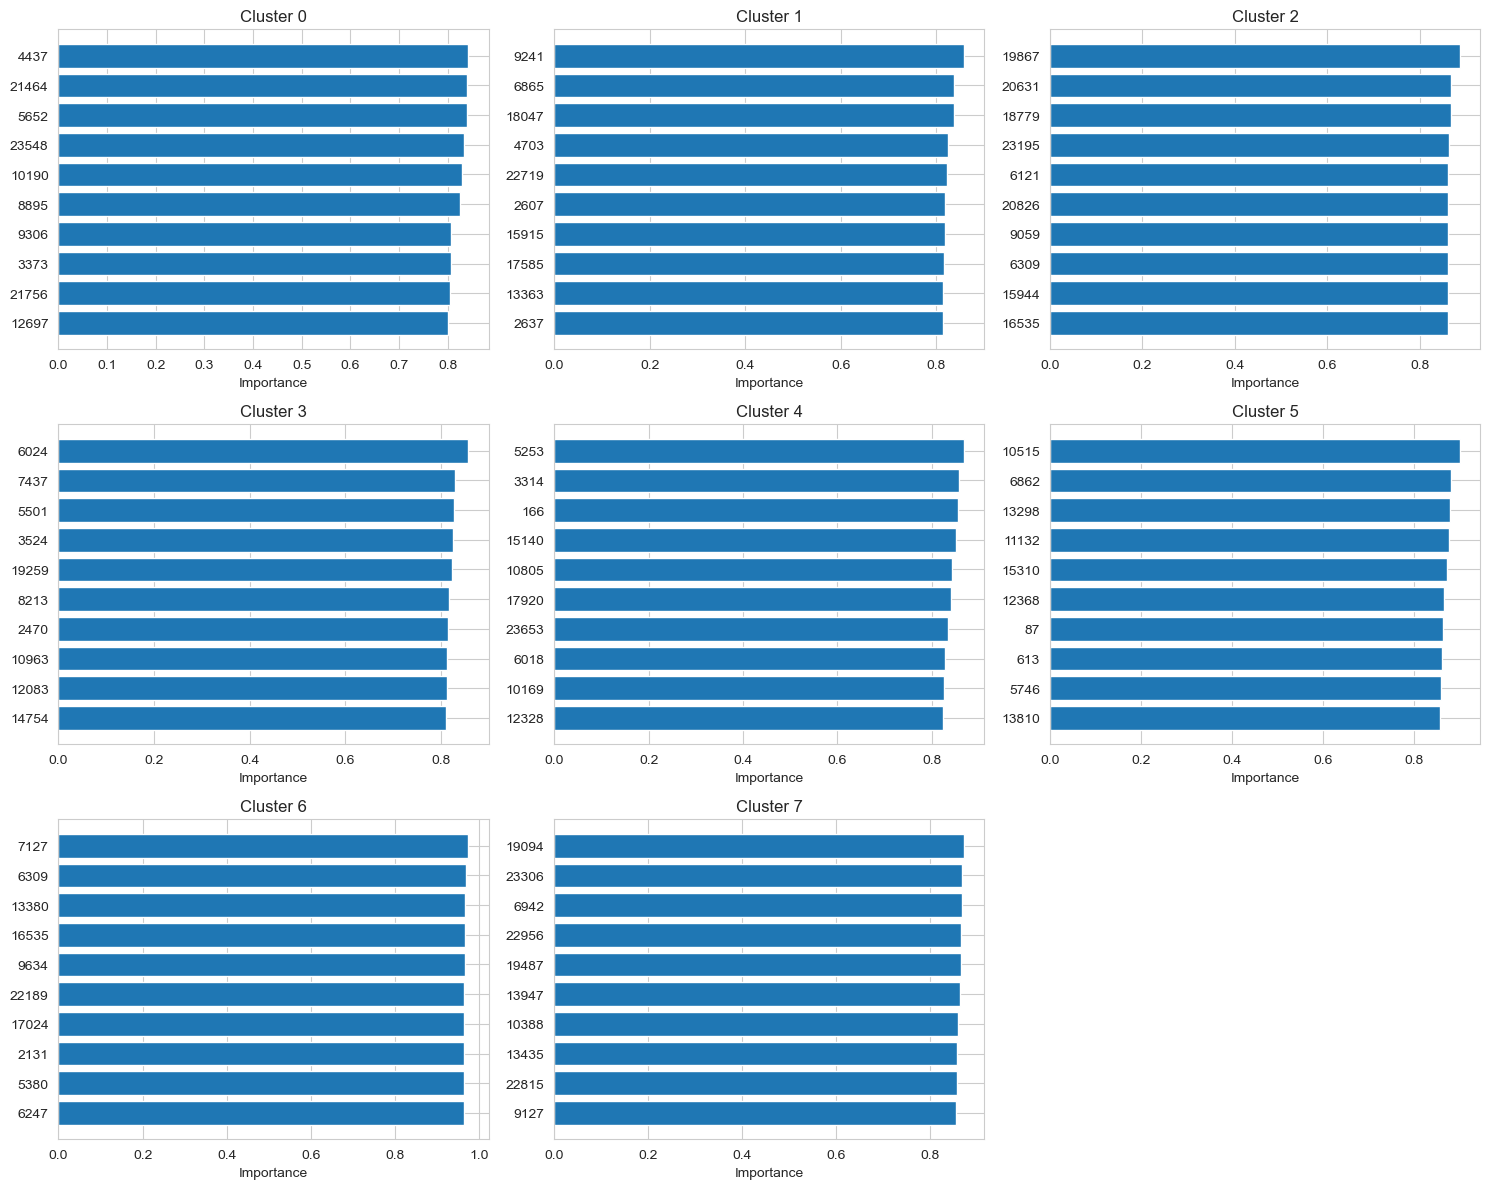

Extraction des documents les plus centraux par cluster...
Documents les plus centraux par cluster:

=== Cluster 0 ===

1. Design and implementation of a 2 μA temperature-compensated MEMS-based real-time clock with ±4 ppm timekeeping accuracy
   Abstract: This paper presents the design and measurements of a temperature-compensated real-time clock based on a silicon resonator. The system exhibits timekeeping accuracy of ±4 ppm over the −40 to 85 °C temp...
   Similarité: 0.8067

2. A 5.92-Mb/mm 2 28-nm pseudo 2-read/write dual-port SRAM using double pumping circuitry
   Abstract: We propose pseudo dual-port (DP) SRAM by using 6T single-port (SP) SRAM bitcell with double pumping circuitry, which enables 2-read/write (2RW) operation within a clock cycle. The data sequencer for a...
   Similarité: 0.8061

3. Overloaded CDMA interconnect for Network-on-Chip (OCNoC)
   Abstract: Networks on Chip (NoCs) have replaced on-chip buses as the paramount communication strategy in large scale Systems-

In [5]:
# 4. Analyse des clusters (exemple avec TF-IDF et K-means)
# selon notre meilleur résultat
best_result_key = 'kmeans_8_doc2vec'  # selon nos résultats (ci-dessus)
analyzer = ClusterAnalyzer(
    df,
    vector_rep.vectorizers['doc2vec'],
    clustering.clustering_results[best_result_key]
)

# Visualisation des clusters
analyzer.visualize_clusters_2d(method='tsne')

# Termes les plus représentatifs
top_terms = analyzer.get_top_terms_per_cluster(n_terms=10)
analyzer.visualize_top_terms(top_terms)

# Documents centraux
central_docs = analyzer.get_central_documents(n_docs=3)
analyzer.display_central_documents(central_docs)

In [6]:
# 5. Ajout des étiquettes de cluster au DataFrame
df_with_clusters = clustering.add_cluster_labels_to_df(best_result_key)

# Vérification des clusters
cluster_counts = df_with_clusters[f'cluster_{best_result_key}'].value_counts()
display(cluster_counts)

Étiquettes de cluster ajoutées dans la colonne 'cluster_kmeans_8_doc2vec'.


cluster_kmeans_8_doc2vec
6    10812
5     2471
7     2270
2     2211
3     1855
1     1561
4     1369
0     1153
Name: count, dtype: int64

In [7]:
# 7. Sauvegarde des résultats
df_with_clusters.to_pickle("articles_with_clusters.pkl")
analyzer.save_analysis_results(output_dir='cluster_analysis')


Extraction des termes les plus représentatifs par cluster...
Extraction des documents les plus centraux par cluster...
Résultats sauvegardés dans le répertoire 'cluster_analysis'.


'cluster_analysis'